# FineTune_LR_scheduler - S5_v6


# Target:

1. FineTune LR scheduler. Set LR=0.1 as before but updated StepSize = 12 and Gamma = 0.2

# Results:

1. Parameters: 7,612
2. Best Train Accuracy: 99.41
3. Best Test Accuracy: 99.49

# Analysis:
1. To get best combination values StepSize = 12 and Gamma =0.2, we tried many trails of these two values.
2. The intuition behind above values is, we observed the accuracy is gradually increasing till around 10 epochs and getting stall from there. So we would like to update LR around 10-12 epochs.
3. We tried with StepSize and Gamma combinations - (10, 0.1), (11, 0.1), (12, 0.1) But didn't help to get the target accuracy consistently at last few epochs.
4. So we thought to increase the speed a little bit after 10-12 epochs by updating gamma = 0.2 and tried these StepSize and Gamma combinations - (10, 0.2), (11, 0.2), (12, 0.2) And finaally Stepsize=12, Gamma=0.2 gave best consistency of >=99.4% in the last 3 epochs and hit maximum of 99.49% with less than 8000 parameters


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [6]:
num_splits = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=32, num_splits=num_splits)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10, num_splits=num_splits)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



cuda


In [8]:
model = Net().to(device)

In [9]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock5): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), 

In [10]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
   GhostBatchNorm-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
   GhostBatchNorm-13           [-1, 16, 10, 10]              32
           Conv2d-14             [-1, 3

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
def get_current_train_acc(model, train_loader):
  model.eval()
  train_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
  train_loss /= len(train_loader.dataset)

  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      train_loss, correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))
  
  train_acc = 100. * correct / len(train_loader.dataset)
  return train_acc, train_loss

In [19]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, lambda_l1=0, train_acc=[], train_losses=[]):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #train_losses.append(loss)

    # L1 regularisation

    l1 = 0
    for p in model.parameters():
      l1 += p.abs().sum()
    loss += lambda_l1 * l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Current_train_batch_accuracy={100*correct/processed:0.2f}')
  current_train_acc, current_train_loss = get_current_train_acc(model, train_loader)
  train_acc.append(current_train_acc)
  train_losses.append(current_train_loss)
  return train_acc, train_losses

def test(model, device, test_loader, test_acc=[], test_losses=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_acc, test_losses


# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 15
scheduler = StepLR(optimizer, step_size=12, gamma=0.2)
best_test_acc = 0
best_model = ''

for epoch in range(EPOCHS):
    print(f" ***** EPOCH:{epoch} ***** ")
    train_acc, train_losses = train(model, device, train_loader, optimizer)
    scheduler.step()
    test_acc, test_losses = test(model, device, test_loader)
    if test_acc[-1]>best_test_acc:
      best_test_acc = test_acc[-1]
      best_model = model
final_test_acc, final_test_loss = test(best_model, device, test_loader)
print(final_test_acc, final_test_loss)

  0%|          | 0/469 [00:00<?, ?it/s]

 ***** EPOCH:0 ***** 


Loss=0.08683709055185318 Batch_id=468 Current_train_batch_accuracy=93.36: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]



Train set: Average loss: 0.0842, Accuracy: 58702/60000 (97.84%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9812/10000 (98.12%)

 ***** EPOCH:1 ***** 


Loss=0.14135922491550446 Batch_id=468 Current_train_batch_accuracy=97.73: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]



Train set: Average loss: 0.0722, Accuracy: 58818/60000 (98.03%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9858/10000 (98.58%)

 ***** EPOCH:2 ***** 


Loss=0.05348518490791321 Batch_id=468 Current_train_batch_accuracy=98.21: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]



Train set: Average loss: 0.0503, Accuracy: 59146/60000 (98.58%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9878/10000 (98.78%)

 ***** EPOCH:3 ***** 


Loss=0.02911928854882717 Batch_id=468 Current_train_batch_accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]



Train set: Average loss: 0.0432, Accuracy: 59324/60000 (98.87%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9898/10000 (98.98%)

 ***** EPOCH:4 ***** 


Loss=0.03569557145237923 Batch_id=468 Current_train_batch_accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]



Train set: Average loss: 0.0407, Accuracy: 59334/60000 (98.89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9903/10000 (99.03%)

 ***** EPOCH:5 ***** 


Loss=0.03879142180085182 Batch_id=468 Current_train_batch_accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]



Train set: Average loss: 0.0435, Accuracy: 59240/60000 (98.73%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9894/10000 (98.94%)

 ***** EPOCH:6 ***** 


Loss=0.039001550525426865 Batch_id=468 Current_train_batch_accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]



Train set: Average loss: 0.0360, Accuracy: 59376/60000 (98.96%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9905/10000 (99.05%)

 ***** EPOCH:7 ***** 


Loss=0.016448643058538437 Batch_id=468 Current_train_batch_accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]



Train set: Average loss: 0.0349, Accuracy: 59411/60000 (99.02%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

 ***** EPOCH:8 ***** 


Loss=0.040543392300605774 Batch_id=468 Current_train_batch_accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]



Train set: Average loss: 0.0305, Accuracy: 59483/60000 (99.14%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9929/10000 (99.29%)

 ***** EPOCH:9 ***** 


Loss=0.014625023119151592 Batch_id=468 Current_train_batch_accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]



Train set: Average loss: 0.0299, Accuracy: 59481/60000 (99.14%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9911/10000 (99.11%)

 ***** EPOCH:10 ***** 


Loss=0.013839495368301868 Batch_id=468 Current_train_batch_accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]



Train set: Average loss: 0.0271, Accuracy: 59551/60000 (99.25%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

 ***** EPOCH:11 ***** 


Loss=0.03335690125823021 Batch_id=468 Current_train_batch_accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]



Train set: Average loss: 0.0258, Accuracy: 59563/60000 (99.27%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

 ***** EPOCH:12 ***** 


Loss=0.010218736715614796 Batch_id=468 Current_train_batch_accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]



Train set: Average loss: 0.0192, Accuracy: 59683/60000 (99.47%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

 ***** EPOCH:13 ***** 


Loss=0.03990017995238304 Batch_id=468 Current_train_batch_accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]



Train set: Average loss: 0.0181, Accuracy: 59712/60000 (99.52%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

 ***** EPOCH:14 ***** 


Loss=0.057281479239463806 Batch_id=468 Current_train_batch_accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]



Train set: Average loss: 0.0183, Accuracy: 59710/60000 (99.52%)


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

[98.12, 98.58, 98.78, 98.98, 99.03, 98.94, 99.05, 99.08, 99.29, 99.11, 99.13, 99.14, 99.34, 99.34, 99.34, 99.34] [0.06644966292381287, 0.05501480507850647, 0.043132723930478095, 0.037558659265190364, 0.036021949243545535, 0.038343796795606615, 0.03410746248587966, 0.03153630826026201, 0.026294874428864568, 0.029761803829390556, 0.027546424252912403, 0.02922300152182579, 0.02187481429502368, 0.021581501349806787, 0.02188341349978, 0.02188341368883848]


Text(0.5, 1.0, 'Test Accuracy')

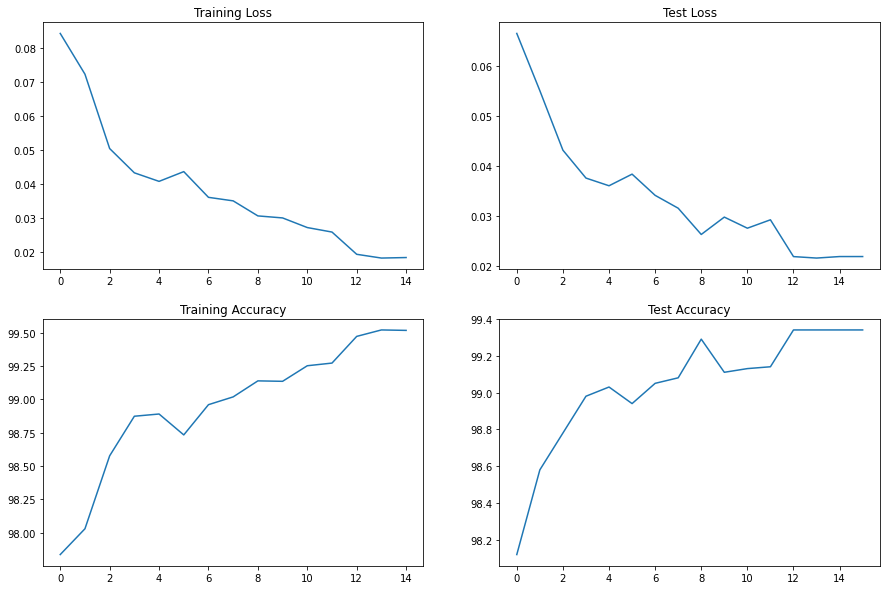

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")